# Capstone Project: Inventory Monitoring at Distribution Centers
The goal of this project is to build Machine learning model that classifies
the number of objects in bins located in distribution centers. In order to accomplish this, I will leverage AWS Sagemaker to perform transfer learning on a Pytorch pre-trained ResNet50 model. Besides that, I will perform profilling and debugging, in order to evaluate how the pipeline could be improved.

### Environment configuration

In [ ]:
%%capture 
!pip install smdebug torch torchvision tqdm

### Imports

In [85]:
from tqdm import tqdm
from random import shuffle
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import sagemaker
import IPython
import io
import requests
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from sagemaker.predictor import Predictor
from mpl_toolkits.axes_grid1 import host_subplot

## Data Preparation

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [8]:
import os
import json
import boto3

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [02:16<00:00,  8.96it/s]


100%|██████████| 2299/2299 [04:25<00:00,  8.66it/s]


100%|██████████| 2666/2666 [05:10<00:00,  8.59it/s]


100%|██████████| 2373/2373 [04:28<00:00,  8.82it/s]


100%|██████████| 1875/1875 [03:30<00:00,  8.92it/s]


## Dataset

The Amazon Bin Image Dataset contains over 500,000 images and metadata from bins of a pod in an operating Amazon Fulfillment Center. The bin images in this dataset are captured as robot units carry pods as part of normal Amazon Fulfillment Center operations.
We are working with a subset of this data tha contains:
- 1228 images with 1 objects
- 2299 images with 2 objects
- 2666 images with 3 objects
- 2373 images with 4 objects
- 1875 images with 5 objects

Image format: JPEG
Image size: (584, 556)
Image mode: RGB


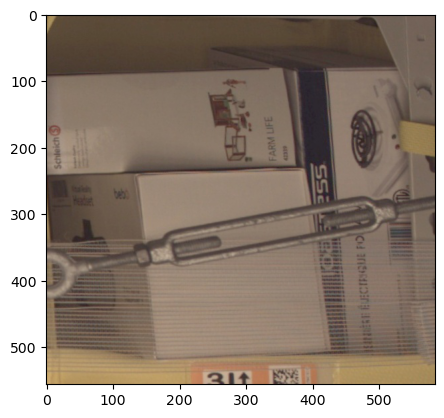

In [22]:
image = Image.open('train_data/processed/train/3/00039.jpg')
print(f'Image format: {image.format}')
print(f'Image size: {image.size}')
print(f'Image mode: {image.mode}')
plt.imshow(image)
plt.show()

### splitting dataset into train, valid and test set folders

In [7]:
os.makedirs('train_data/processed', exist_ok=True)
os.makedirs('train_data/processed/train', exist_ok=True)
os.makedirs('train_data/processed/valid', exist_ok=True)
os.makedirs('train_data/processed/test', exist_ok=True)

In [20]:
for split in ['train', 'valid', 'test']:
    for i in range(1, 6):
        os.makedirs(os.path.join('train_data/processed', split, str(i)))

In [21]:
for i in range(1, 6):
    print(f"splitting Images with {i} objects...")
    path = f'train_data/{i}'
    files = os.listdir(path)
    # shuffling files
    shuffle(files)
    # 80% going for training
    limit = int(.8 * len(files))
    train_files, tmp = files[:limit], files[limit:]
    # 10% going for validation and 10% going for testing
    limit = int(.5 * len(tmp))
    valid_files, test_files = tmp[:limit], tmp[limit:]
    
    train_path, valid_path, test_path = f'train_data/processed/train/{i}/', f'train_data/processed/valid/{i}/', f'train_data/processed/test/{i}/'
    
    for file in train_files:
        shutil.copy2(os.path.join(path,file), train_path)
    for file in valid_files:
        shutil.copy2(os.path.join(path,file), valid_path)
    for file in test_files:
        shutil.copy2(os.path.join(path,file), test_path)

splitting Images with 1 objects...
splitting Images with 2 objects...
splitting Images with 3 objects...
splitting Images with 4 objects...
splitting Images with 5 objects...


### Uploading the data to AWS S3

In [ ]:
%%capture
! aws s3 sync train_data/processed/ s3://sagemaker-us-east-1-031699854505/data/

## Model Training

In [55]:
# declaring hyperparameters
hyperparameters = {
    "batch-size": 32,
    "lr": 0.001,
    "epochs": 3
}

In [56]:
# declaring profiler and debugger rules
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [57]:
# creating estimator

estimator = PyTorch(
    entry_point="train.py",
    base_job_name="capstone-classifier",
    framework_version='1.13',
    py_version='py39',
    role=sagemaker.get_execution_role(),
    instance_type='ml.c5.xlarge',
    instance_count=2, 
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config
)

In [58]:
# fitting estimator 
estimator.fit({"data": "s3://sagemaker-us-east-1-031699854505/data/"}, wait=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.


Using provided s3_resource


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: capstone-classifier-2023-09-23-20-43-46-816


2023-09-23 20:43:47 Starting - Starting the training job...
2023-09-23 20:44:18 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-09-23 20:45:18 Downloading - Downloading input data......
2023-09-23 20:46:18 Training - Downloading the training image...
2023-09-23 20:46:39 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-09-23 20:46:35,511 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-09-23 20:46:35,513 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-09-23 20:46:35,515 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-09-23 20:46:35,525 sagemaker_pytorch_container.training INF

# sagemaker debugger and profiler results

In [61]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())

[2023-09-23 22:02:02.189 pytorch-2-0-0-cpu-py3-ml-t3-medium-11e14ffd7983b6f26dbcb1db6410:24017 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-031699854505/capstone-classifier-2023-09-23-20-43-46-816/debug-output
[2023-09-23 22:02:02.856 pytorch-2-0-0-cpu-py3-ml-t3-medium-11e14ffd7983b6f26dbcb1db6410:24017 WARNING s3handler.py:184] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 235 more expected)', IncompleteRead(0 bytes read, 235 more expected)) while reading s3://sagemaker-us-east-1-031699854505/capstone-classifier-2023-09-23-20-43-46-816/debug-output/index/000000000/000000000116_worker_0.json . Will retry now
[2023-09-23 22:02:20.152 pytorch-2-0-0-cpu-py3-ml-t3-medium-11e14ffd7983b6f26dbcb1db6410:24017 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-09-23 22:02:21.181 pytorch-2-0-0-cpu-py3-ml-t3-medium-11e14ffd7983b6f26dbcb1db6410:240

In [66]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


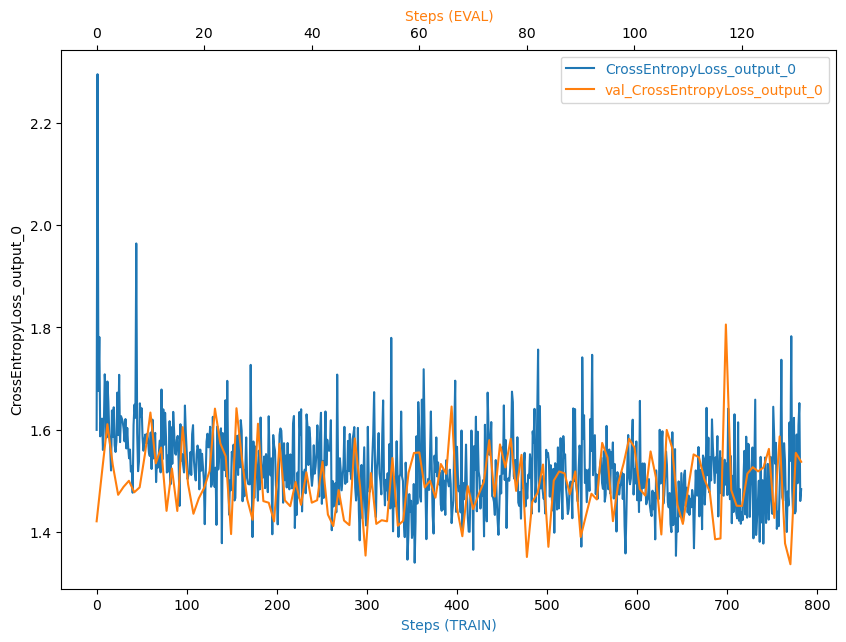

In [67]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

In [71]:
profiler_outputs = 's3://sagemaker-us-east-1-031699854505/capstone-classifier-2023-09-23-20-43-46-816/rule-output/ProfilerReport/profiler-output/'

In [74]:
!aws s3 sync {profiler_outputs} profiler_outputs/

download: s3://sagemaker-us-east-1-031699854505/capstone-classifier-2023-09-23-20-43-46-816/rule-output/ProfilerReport/profiler-output/profiler-report.html to profiler_outputs/profiler-report.html
download: s3://sagemaker-us-east-1-031699854505/capstone-classifier-2023-09-23-20-43-46-816/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to profiler_outputs/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-us-east-1-031699854505/capstone-classifier-2023-09-23-20-43-46-816/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to profiler_outputs/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-031699854505/capstone-classifier-2023-09-23-20-43-46-816/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to profiler_outputs/profiler-report.ipynb
download: s3://sagemaker-us-east-1-031699854505/capstone-classifier-2023-09-23-20-43-46-816/rule-output/ProfilerReport/profiler-output/pro

In [75]:
IPython.display.HTML(filename='profiler_outputs/profiler-report.html')